In [63]:
ВАШЕ_ИМЯ_И_ФАМИЛИЯ = "Мажаров Иван"

---

In [1]:
import random
import os
import re
import numpy as np
from tqdm import tqdm_notebook
from scipy.sparse import csr_matrix, hstack, issparse, coo_matrix
from string import punctuation
from collections import defaultdict, Counter
from copy import deepcopy
import matplotlib.pyplot as plt

Загружаем данные. У нас есть три выборки: обучающая (train), валидационная (dev) и тестовая (test). На валидационной выборке тестируем классификатор и подбираем гиперпараметры. Результаты работы классификатора на тестовой выборке проверяются на сервере СompAI, метки для нее не предоставляются.

In [2]:
data_dir = '../FILIMDB'

In [3]:
def load_data(file_name):
    """
    Reads specified file, returns list of strings
    :param file_name: file name in data_dir folder
    :returns list of strings
    """
    print('Loading %s' % file_name)
    data_path = os.path.join(data_dir, file_name)
    with open(data_path, 'r', encoding='utf8') as input_data:
        lines = input_data.readlines()
        lines = [l.strip() for l in lines]
    
    print('Loaded %d lines' % len(lines))
    return lines

In [4]:
train_texts, train_labels = load_data('train.texts'), load_data('train.labels')
dev_texts, dev_labels = load_data('dev.texts'), load_data('dev.labels')
test_texts = load_data('test.texts')

Loading train.texts
Loaded 25000 lines
Loading train.labels
Loaded 25000 lines
Loading dev.texts
Loaded 25000 lines
Loading dev.labels
Loaded 25000 lines
Loading test.texts
Loaded 10599 lines


Посмотрим, какие символы встречаются у нас в текстах, выберем из них те, которые мы хотим оставить

In [7]:
char_set = set(ch for review in train_texts for ch in review)
sorted_chars = sorted(list(char_set))
print(''.join(sorted_chars))

	 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ ¡¢£¤¦§¨«­®°³´·º»½¾¿ÀÁÃÄÅÈÉÊÕØÜßàáâãäåæçèéêëìíîïðñòóôöøùúûüýō–‘’“”…₤


In [8]:
def tokenize(text):
    """
    Preprocesses text and split it into the list of words
    :param: text(str): movie review
    """
    # YOUR CODE HERE
    return re.findall('[\w]+', text.lower())

def get_ngrams(tokens, ngram_range):
    return [" ".join(tokens[idx:idx+i]) 
            for i in range(ngram_range[0],ngram_range[1]+1) 
            for idx in range(len(tokens)-i+1)]

def get_tokens(texts, ngram_range=(1,1)):
    return [get_ngrams(tokenize(r), ngram_range) for r in texts]

ngram_range = (1, 1)
tokenized_train_texts = get_tokens(train_texts, ngram_range)
tokenized_dev_texts = get_tokens(dev_texts, ngram_range)
tokenized_test_texts = get_tokens(test_texts, ngram_range)

In [9]:
# sanity check
assert all(len(x) > 0 for x in tokenized_train_texts)
unique_words = set(w for text in tokenized_train_texts for w in text)
for word in ["the", "and", "good"]:
    assert word in unique_words

A Используя скрипты из предыдущего задания, загрузите датасет, сделайте его предобработку
и токенизацию.

In [10]:
# done

Составим словарь из наиболее часто встречающихся в отзывах слов. Может быть полезно удалить из словаря стоп-слова - самые частые слова языка, не несущие важной информации для классификации (например "you", "the", "i" ...). Слова, не вошедшие в словарь, будем обозначать специальным символом "UNK"

Количество слов в словаре - важный гиперпараметр классификатора.

B Постройте словарь, в котором будут содержаться все уникальные токены из обучающей
выборки. **Вопрос 1:** Чему равен размер получившегося словаря?

In [11]:
def get_vocab():
    with open("../stopwords.txt", "r") as f:
        STOPWORDS = map(lambda x: x.strip(), f.readlines())

    STOPWORDS = set(STOPWORDS)

    vocab = []

    for txt in tokenized_train_texts:
        vocab.extend([w for w in txt if w not in STOPWORDS])

    vocab = set(vocab) # for faster searching
    print('Ответ 1: размер словаря - %d' % len(vocab))
    return vocab
vocab = get_vocab()

Ответ 1: размер словаря - 74739


C Для того, чтобы обучить логистическую регрессию необходимо представить обучающую и тестовую выборки в виде матриц размера N ∗ V , где N – количество отзывов в выборке, а V – размер словаря. В такой матрице i-я строка содержит bag-of-words
вектор i-ого отзыва из выборки, j-я компонента которого вычисляется как абсолютная частота (число вхождений) j-го токена из словаря в этот отзыв. Обратите внимание, что большинство значений вектора будут равны 0. В целях оптимальной работы с памятью
воспользуйтесь scipy Compressed Sparse Row matrix.

In [12]:
def get_matrix():
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    for d in tqdm_notebook(tokenized_train_texts):
        for term in d:
            if term in vocab:
                index = vocabulary.setdefault(term, len(vocabulary))
                indices.append(index)
                data.append(1)
        indptr.append(len(indices))

    X_train = csr_matrix((data, indices, indptr), dtype=int)

    indptr = [0]
    indices = []
    data = []
    for d in tqdm_notebook(tokenized_dev_texts):
        for term in d:
            if term in vocab:
                index = vocabulary.setdefault(term, len(vocabulary))
                indices.append(index)
                data.append(1)
        indptr.append(len(indices))

    X_dev = csr_matrix((data, indices, indptr), shape=X_train.shape, dtype=int)
    
    return X_train, X_dev, vocabulary
X_train, X_dev, vocabulary = get_matrix()

In [13]:
y_train = np.array([(lambda l: 1 if l=='pos' else 0)(l) for l in train_labels])
y_dev = np.array([(lambda l: 1 if l=='pos' else 0)(l) for l in dev_labels])

In [14]:
X_train.shape, y_train.size

((25000, 74739), 25000)

Используя формулу обновления весов из теоретической части, реализуйте логистическую регрессию. Для этого 1) реализуйте функцию сигмода; 2) напишите функцию инициализации весов (в качестве начальных значений для $w_j$ можно использовать нули);
3) реализуйте функцию, которая для заданных весов оценивает точность классификатора, считает значение оценочной функции L и находит градиенты $\frac{∂L}{∂w_j}$ ; не используйте циклы - вместо этого используйте матричные операции csr_matrix.dot, numpy.sum и
т.п. 4) напишите функцию, которая используя посчитанные градиенты, обновляет значение весов. Вопрос 2: Во сколько раз  медленнее считается оценочная функция, если реализовать суммирование с помощью цикла?

In [15]:
class LogReg:
    def __init__(self, lr=1e-3, C=1e-3, epochs=1000, optim='adam'):
        self.lr = lr
        self.C = C
        self.epochs = epochs
        self.optim = optim
        
        self.sparse = False
        self.train_losses = []
        self.test_losses = []
        self.train_acc = []
        self.test_acc = []
        
        self.alpha = 0.01
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.eps = 1e-8
        self.t = 0
        
        
    def __sigmoid(self, z): 
        return 1./(1+np.exp(-z))
    
    def __init_weights(self):
        self.w = np.zeros(self.n_features+1)
        self.m = np.zeros(self.n_features+1)
        self.v = np.zeros(self.n_features+1)
    
    def __h(self, x):
        return self.__sigmoid(x)
    
    def __loss(self, h, y):
        return -(y*np.log(h+1e-8)+(1-y)*np.log(1-h+1e-8)).mean() + (self.C*self.w**2).sum()
    
    def __grad(self, X, h, y):
        self.gradient = X.T.dot(h-y)/y.size + 2*self.C*self.w
    
    def __step(self):
        if self.optim == 'adam':
            self.t += 1

            self.m = self.beta1*self.m + (1-self.beta1)*self.gradient
            self.v = self.beta2*self.v + (1-self.beta2)*(self.gradient**2)

            self.m_cap = self.m/(1-(self.beta1**self.t))
            self.v_cap = self.v/(1-(self.beta2**self.t))

            self.w -= self.lr*self.m_cap/(np.sqrt(self.v_cap) + self.eps)
        elif self.optim == 'sgd':
            self.w -= self.lr*self.gradient
        
        
    def fit(self, X_train, y_train, X_test, y_test):
        self.n_samples, self.n_features = X_train.shape
        if issparse(X_train):
            self.sparse = True
        if self.sparse:
            X_train = hstack([np.ones((self.n_samples, 1)), X_train])
            X_test = hstack([np.ones((self.n_samples, 1)), X_test])
            #X = hstack((X,np.ones(self.n_samples)[:,None]))
        else:
            X_train = np.concatenate((np.ones((self.n_samples, 1)), X_train), axis=1)
            X_test = np.concatenate((np.ones((self.n_samples, 1)), X_test), axis=1)
        
        self.__init_weights()
        for i in range(self.epochs):
            z = X_train.dot(self.w)
            h = self.__sigmoid(z)
            self.__grad(X_train, h, y_train)
            self.__step()
            
            #if(i % 1000 == 0):
            #print(f'loss: {self.__loss(z, y)} \t')
            self.train_losses.append(self.__loss(h, y_train))
            self.train_acc.append((y_train == h.round()).mean())
            
            z = X_test.dot(self.w)
            h = self.__sigmoid(z)
            self.test_losses.append(self.__loss(h, y_test))
            self.test_acc.append((y_test == h.round()).mean())
            
    def predict_prob(self, X):
        self.n_samples, self.n_features = X.shape
        if issparse(X):
            self.sparse = True
        if self.sparse:
            X = hstack([np.ones((self.n_samples, 1)), X])
    
        return self.__sigmoid(X.dot(self.w))
    
    def predict(self, X):
        return self.predict_prob(X).round()
    
    def score(self, X, y):
        return (y == self.predict(X)).mean()

In [16]:
def plot(model):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(model.train_losses, label='Train')
    plt.plot(model.test_losses, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(model.train_acc, label='Train accuracy')
    plt.plot(model.test_acc, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.ylim(0.8, 1.0)
    plt.grid()
    plt.show()

# Эксперименты с темпом обучения, коэффициентом регуляризации и n-граммами

Ниже [было] ооооочень много графиков, но оказалось, что тогда файл весит слишком много

Краткие выводы: 
* при низком темпе обучения решение не сходится, при высоком надо слишком много итераций
* при маленьком коэффиенте регуляризации наблюдается переобучение (растет функция потерь на тесте), при большом модель становится слишком неустойчивой
* биграммы и триграммы улучшают точность
* Адам сходится гораздо быстрее, чем градиентный спуск.

## Adam

### 1-1

In [61]:
ngram_range = (1, 1)
tokenized_train_texts = get_tokens(train_texts, ngram_range)
tokenized_dev_texts = get_tokens(dev_texts, ngram_range)

vocab = get_vocab()
X_train, X_dev, vocabulary = get_matrix()
X_train.shape, X_dev.shape

Ответ 1: размер словаря - 74739


((25000, 74739), (25000, 74739))

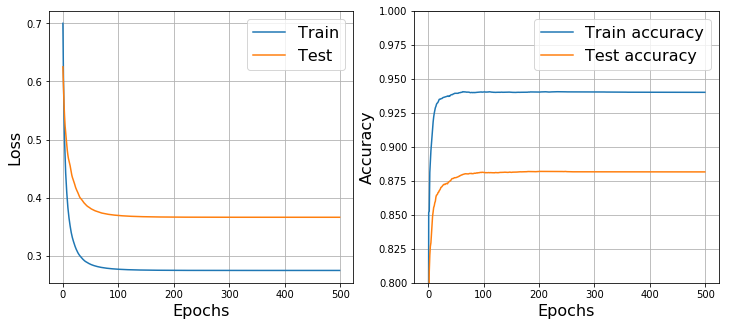

Params: lr - 1E-02, alpha - 1E-03
Score: train - 0.940120, test - 0.881600


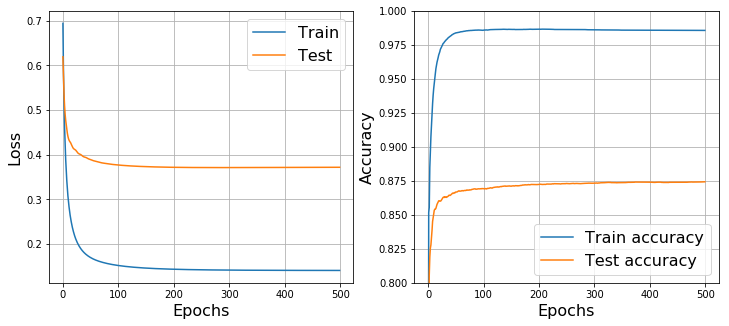

Params: lr - 1E-02, alpha - 1E-04
Score: train - 0.985720, test - 0.874320


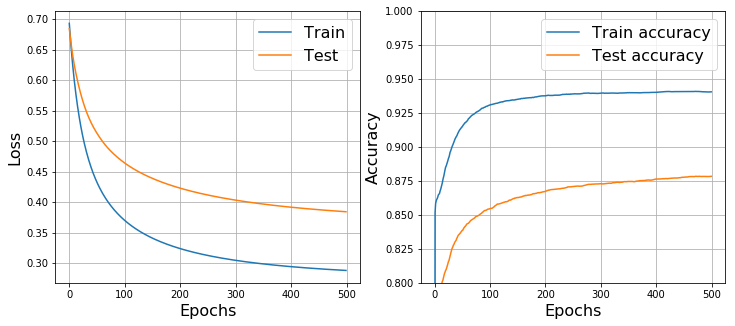

Params: lr - 1E-03, alpha - 1E-03
Score: train - 0.940480, test - 0.878360


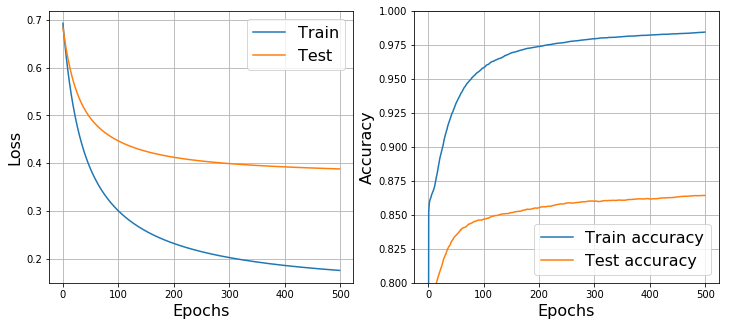

Params: lr - 1E-03, alpha - 1E-04
Score: train - 0.984520, test - 0.864240


In [62]:
for lr in [1e-2, 1e-3]:
    for alpha in [1e-3, 1e-4]:
        model = LogReg(lr=lr, C=alpha, epochs=500)
        model.fit(X_train, y_train, X_dev, y_dev)
        plot(model)
        print("Params: lr - %.0E, alpha - %.0E" %(lr, alpha))
        print('Score: train - %f, test - %f' %(model.score(X_train, y_train), model.score(X_dev, y_dev)))

### 1-2

In [25]:
ngram_range = (1, 2)
tokenized_train_texts = get_tokens(train_texts, ngram_range)
tokenized_dev_texts = get_tokens(dev_texts, ngram_range)

vocab = get_vocab()
X_train, X_dev, vocabulary = get_matrix()
X_train.shape, X_dev.shape

Ответ 1: размер словаря - 1454922


((25000, 1454922), (25000, 1454922))

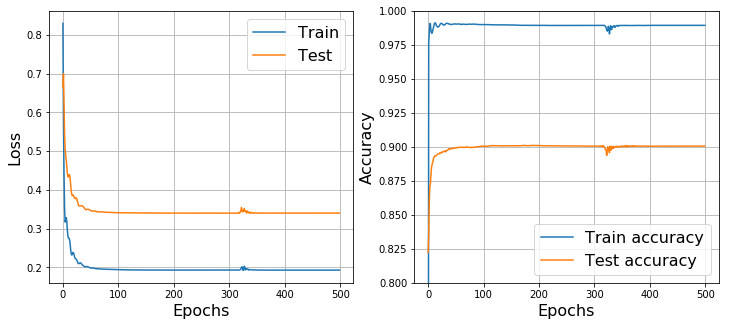

Params: lr - 1E-02, alpha - 1E-03
Score: train - 0.989440, test - 0.900600


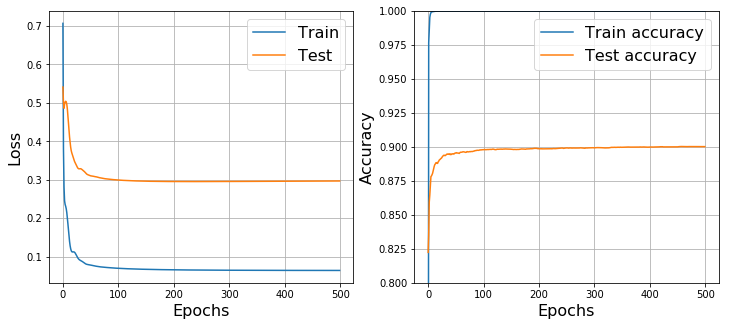

Params: lr - 1E-02, alpha - 1E-04
Score: train - 0.999960, test - 0.900200


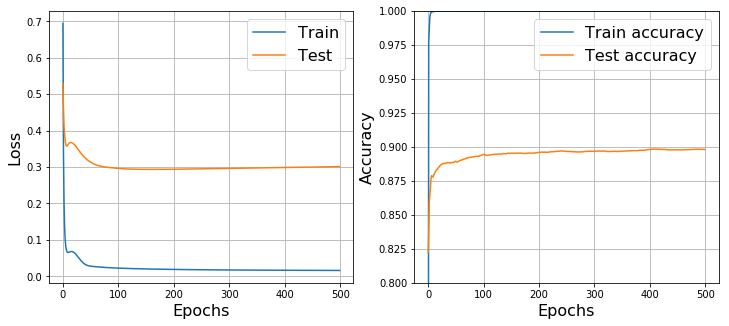

Params: lr - 1E-02, alpha - 1E-05
Score: train - 1.000000, test - 0.898120


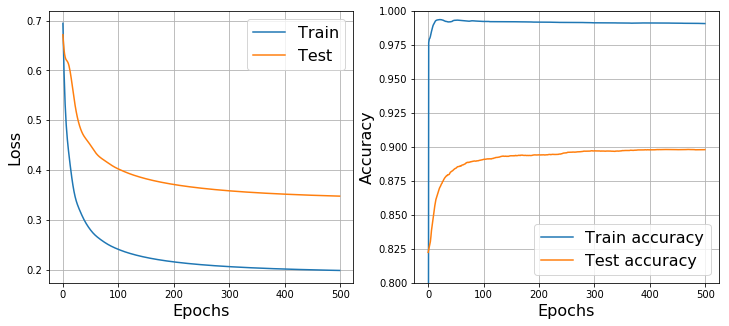

Params: lr - 1E-03, alpha - 1E-03
Score: train - 0.990760, test - 0.898000


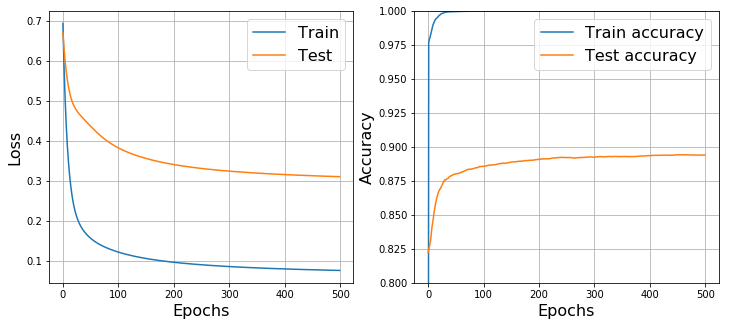

Params: lr - 1E-03, alpha - 1E-04
Score: train - 0.999960, test - 0.894000


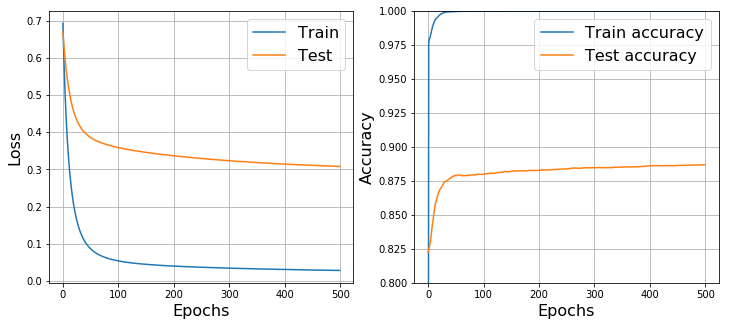

Params: lr - 1E-03, alpha - 1E-05
Score: train - 1.000000, test - 0.886920


In [26]:
for lr in [1e-2, 1e-3]:
    for alpha in [1e-3, 1e-4, 1e-5]:
        model = LogReg(lr=lr, C=alpha, epochs=500)
        model.fit(X_train, y_train, X_dev, y_dev)
        plot(model)
        print("Params: lr - %.0E, alpha - %.0E" %(lr, alpha))
        print('Score: train - %f, test - %f' %(model.score(X_train, y_train), model.score(X_dev, y_dev)))

### 1-3

In [27]:
ngram_range = (1, 3)
tokenized_train_texts = get_tokens(train_texts, ngram_range)
tokenized_dev_texts = get_tokens(dev_texts, ngram_range)

vocab = get_vocab()
X_train, X_dev, vocabulary = get_matrix()
X_train.shape, X_dev.shape

Ответ 1: размер словаря - 5072444


((25000, 5072444), (25000, 5072444))

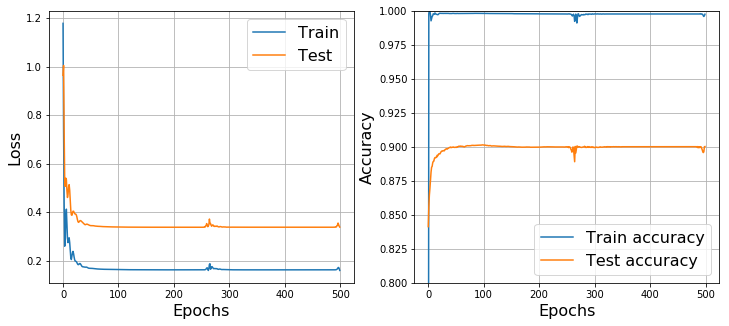

Params: lr - 1E-02, alpha - 1E-03
Score: train - 0.997680, test - 0.900240


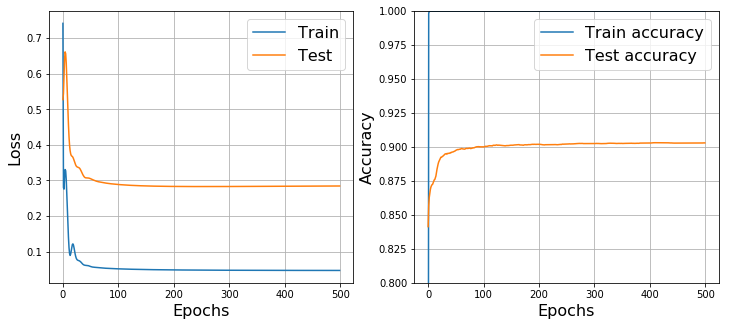

Params: lr - 1E-02, alpha - 1E-04
Score: train - 1.000000, test - 0.902920


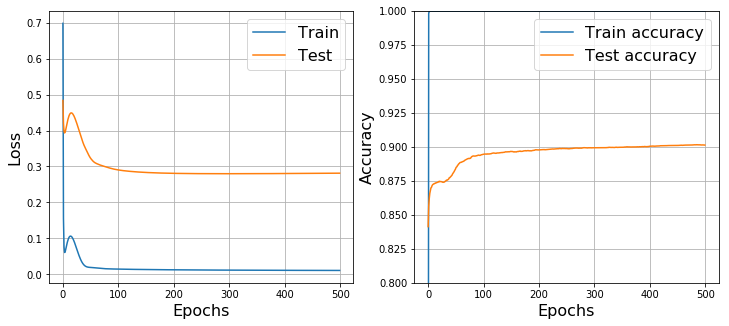

Params: lr - 1E-02, alpha - 1E-05
Score: train - 1.000000, test - 0.901320


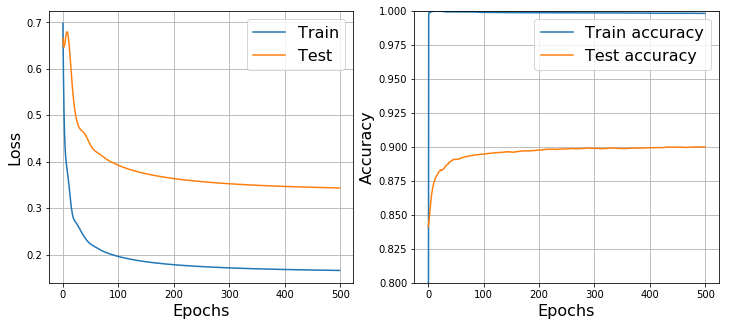

Params: lr - 1E-03, alpha - 1E-03
Score: train - 0.998240, test - 0.899920


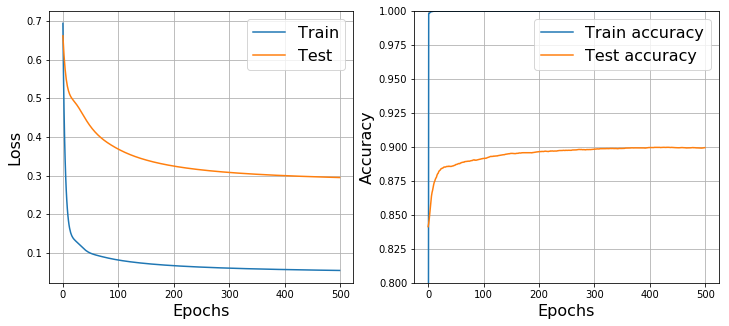

Params: lr - 1E-03, alpha - 1E-04
Score: train - 1.000000, test - 0.899440


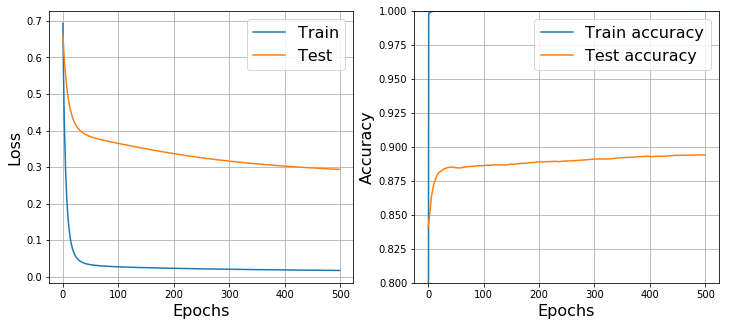

Params: lr - 1E-03, alpha - 1E-05
Score: train - 1.000000, test - 0.893960


In [28]:
for lr in [1e-2, 1e-3]:
    for alpha in [1e-3, 1e-4, 1e-5]:
        model = LogReg(lr=lr, C=alpha, epochs=500)
        model.fit(X_train, y_train, X_dev, y_dev)
        plot(model)
        print("Params: lr - %.0E, alpha - %.0E" %(lr, alpha))
        print('Score: train - %f, test - %f' %(model.score(X_train, y_train), model.score(X_dev, y_dev)))

### 2-3

In [31]:
ngram_range = (2,3)
tokenized_train_texts = get_tokens(train_texts, ngram_range)
tokenized_dev_texts = get_tokens(dev_texts, ngram_range)

vocab = get_vocab()
X_train, X_dev, vocabulary = get_matrix()
X_train.shape, X_dev.shape

Ответ 1: размер словаря - 4997705


((25000, 4997705), (25000, 4997705))

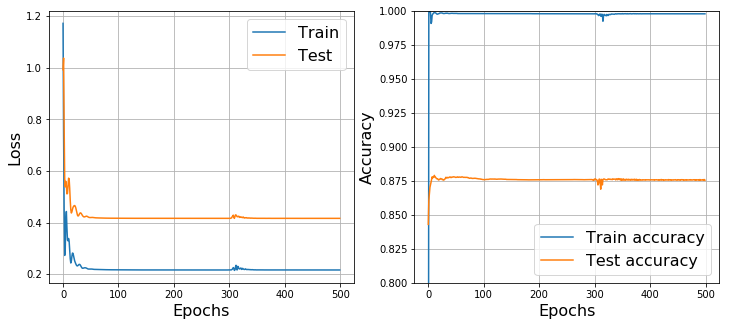

Params: lr - 1E-02, alpha - 1E-03
Score: train - 0.997960, test - 0.875520


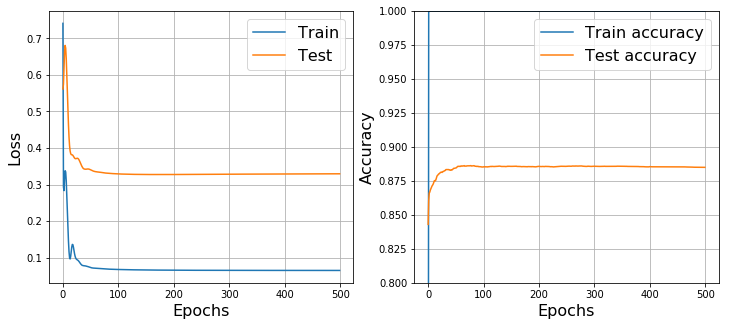

Params: lr - 1E-02, alpha - 1E-04
Score: train - 0.999960, test - 0.884960


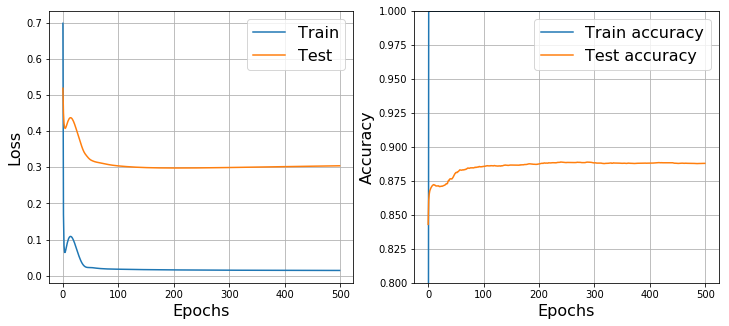

Params: lr - 1E-02, alpha - 1E-05
Score: train - 1.000000, test - 0.887880


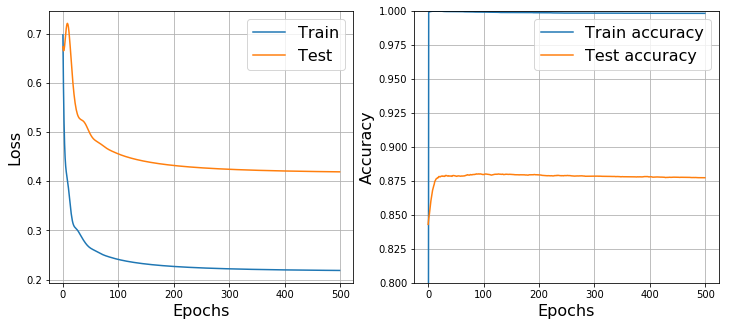

Params: lr - 1E-03, alpha - 1E-03
Score: train - 0.998280, test - 0.877320


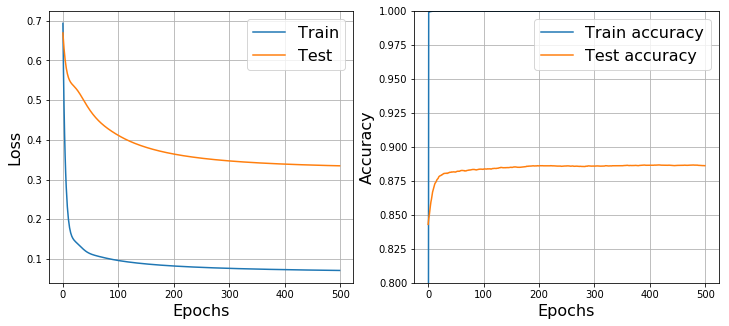

Params: lr - 1E-03, alpha - 1E-04
Score: train - 1.000000, test - 0.886200


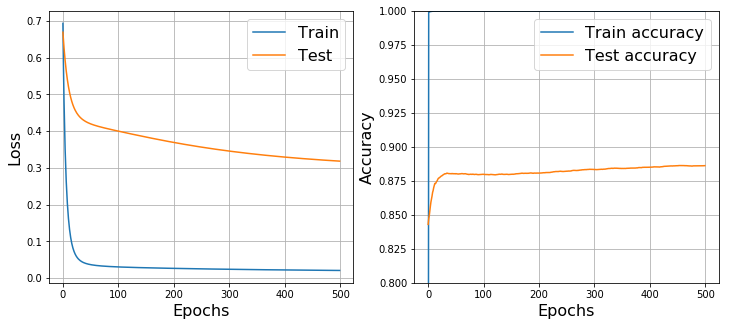

Params: lr - 1E-03, alpha - 1E-05
Score: train - 1.000000, test - 0.886200


In [32]:
for lr in [1e-2, 1e-3]:
    for alpha in [1e-3, 1e-4, 1e-5]:
        model = LogReg(lr=lr, C=alpha, epochs=500)
        model.fit(X_train, y_train, X_dev, y_dev)
        plot(model)
        print("Params: lr - %.0E, alpha - %.0E" %(lr, alpha))
        print('Score: train - %f, test - %f' %(model.score(X_train, y_train), model.score(X_dev, y_dev)))

# SGD

### 1-1

In [33]:
ngram_range = (1, 1)
tokenized_train_texts = get_tokens(train_texts, ngram_range)
tokenized_dev_texts = get_tokens(dev_texts, ngram_range)

vocab = get_vocab()
X_train, X_dev, vocabulary = get_matrix()
X_train.shape, X_dev.shape

Ответ 1: размер словаря - 74739


((25000, 74739), (25000, 74739))

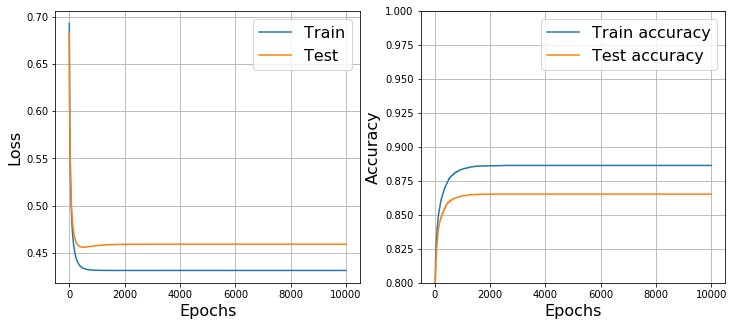

Params: lr - 1E-01, alpha - 1E-02
Score: train - 0.886360, test - 0.865240


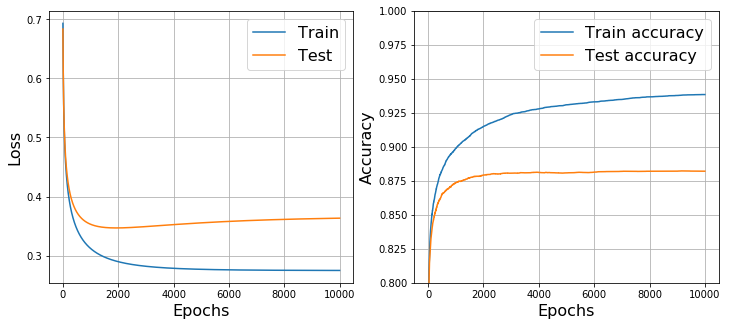

Params: lr - 1E-01, alpha - 1E-03
Score: train - 0.938520, test - 0.882120


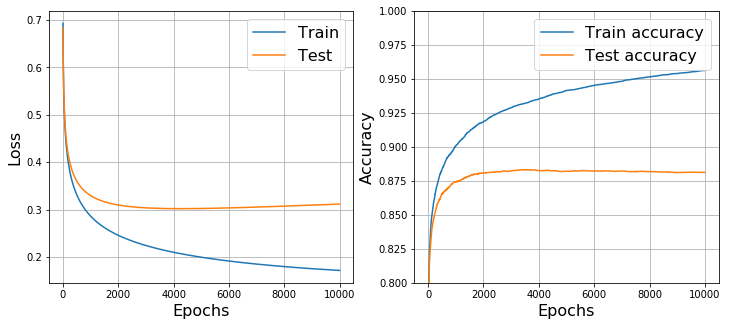

Params: lr - 1E-01, alpha - 1E-04
Score: train - 0.956280, test - 0.881240


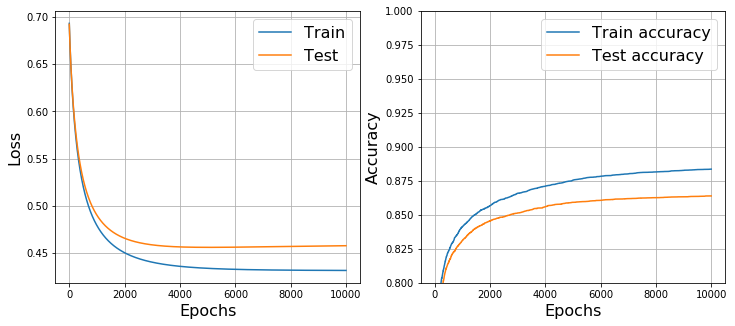

Params: lr - 1E-02, alpha - 1E-02
Score: train - 0.883640, test - 0.863920


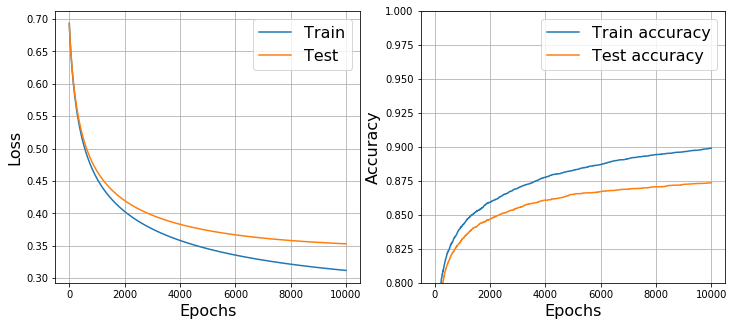

Params: lr - 1E-02, alpha - 1E-03
Score: train - 0.899040, test - 0.873520


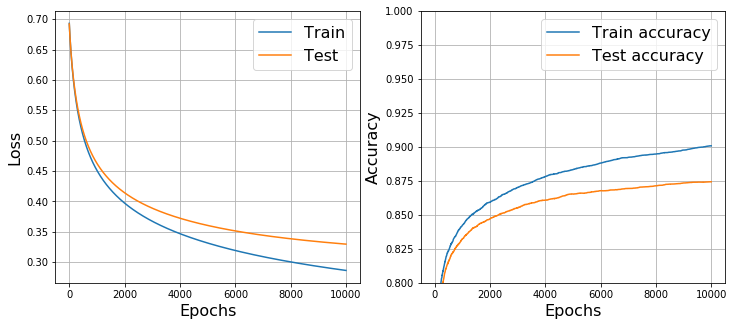

Params: lr - 1E-02, alpha - 1E-04
Score: train - 0.900800, test - 0.874320


In [34]:
for lr in [1e-1, 1e-2]:
    for alpha in [1e-2, 1e-3, 1e-4]:
        model = LogReg(lr=lr, C=alpha, epochs=10000, optim='sgd')
        model.fit(X_train, y_train, X_dev, y_dev)
        plot(model)
        print("Params: lr - %.0E, alpha - %.0E" %(lr, alpha))
        print('Score: train - %f, test - %f' %(model.score(X_train, y_train), model.score(X_dev, y_dev)))

### 1-2

In [35]:
ngram_range = (1, 2)
tokenized_train_texts = get_tokens(train_texts, ngram_range)
tokenized_dev_texts = get_tokens(dev_texts, ngram_range)

vocab = get_vocab()
X_train, X_dev, vocabulary = get_matrix()
X_train.shape, X_dev.shape

Ответ 1: размер словаря - 1454922


((25000, 1454922), (25000, 1454922))

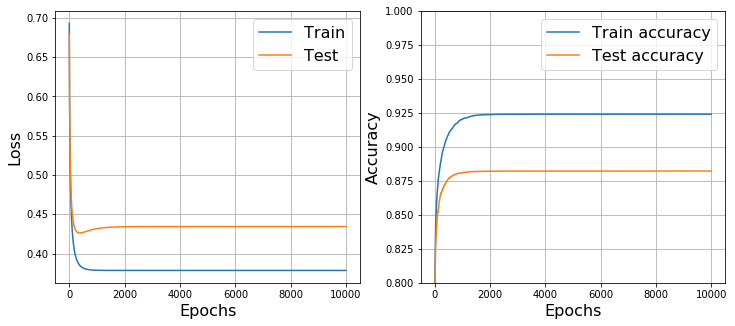

Params: lr - 1E-01, alpha - 1E-02
Score: train - 0.924080, test - 0.882240


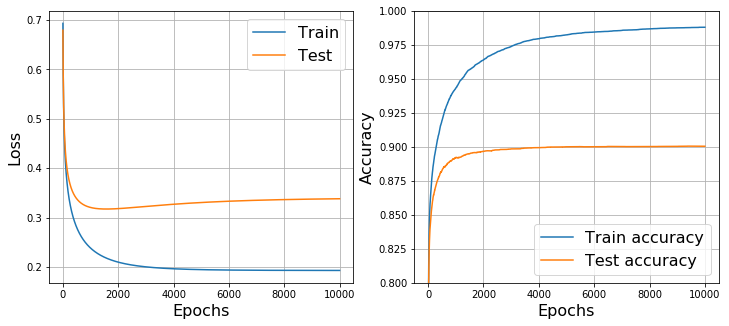

Params: lr - 1E-01, alpha - 1E-03
Score: train - 0.988040, test - 0.900480


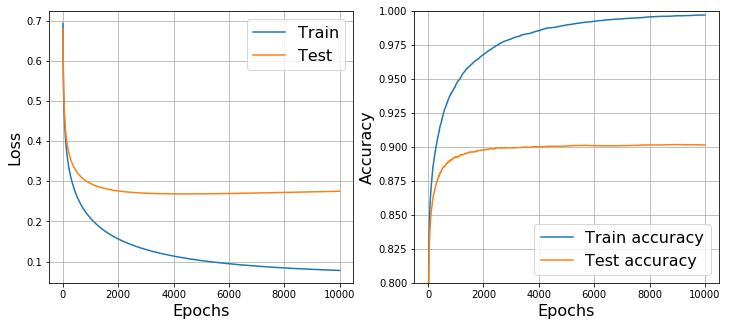

Params: lr - 1E-01, alpha - 1E-04
Score: train - 0.997080, test - 0.901400


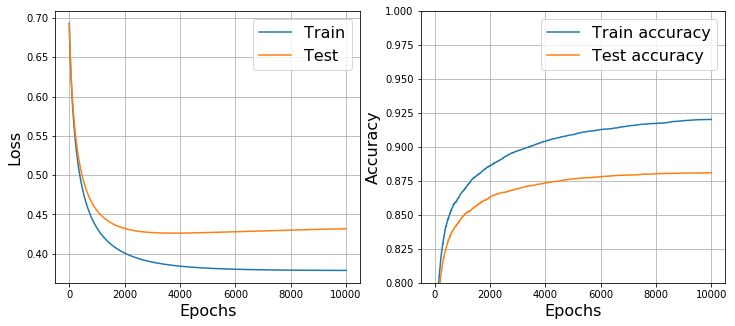

Params: lr - 1E-02, alpha - 1E-02
Score: train - 0.920240, test - 0.880920


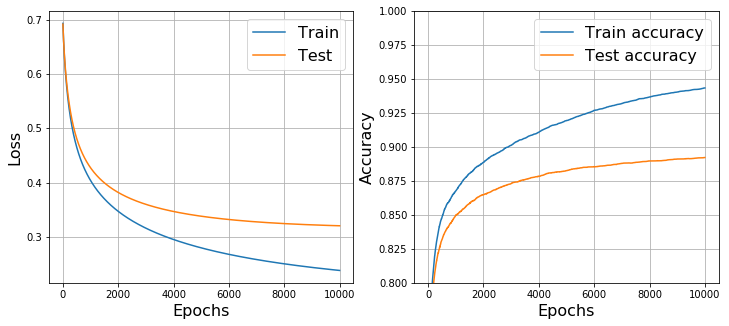

Params: lr - 1E-02, alpha - 1E-03
Score: train - 0.943360, test - 0.892200


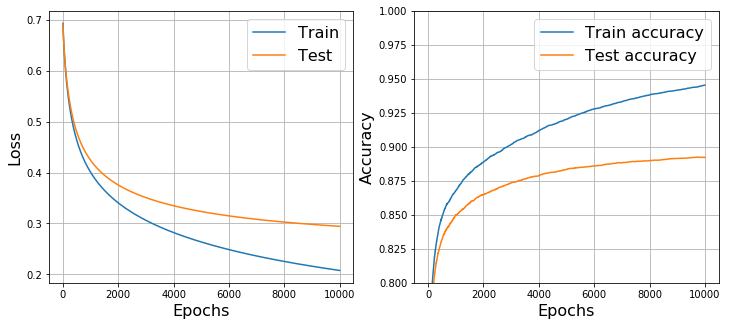

Params: lr - 1E-02, alpha - 1E-04
Score: train - 0.945440, test - 0.892280


In [36]:
for lr in [1e-1, 1e-2]:
    for alpha in [1e-2, 1e-3, 1e-4]:
        model = LogReg(lr=lr, C=alpha, epochs=10000, optim='sgd')
        model.fit(X_train, y_train, X_dev, y_dev)
        plot(model)
        print("Params: lr - %.0E, alpha - %.0E" %(lr, alpha))
        print('Score: train - %f, test - %f' %(model.score(X_train, y_train), model.score(X_dev, y_dev)))

In [38]:
ngram_range = (1, 1)
tokenized_train_texts = get_tokens(train_texts, ngram_range)
tokenized_dev_texts = get_tokens(dev_texts, ngram_range)

vocab = get_vocab()
X_train, X_dev, vocabulary = get_matrix()
X_train.shape, X_dev.shape

Ответ 1: размер словаря - 74739


((25000, 74739), (25000, 74739))

In [60]:
for lr in [1e-2]:
    for alpha in [1e-3]:
        model = LogReg(lr=lr, C=alpha, epochs=500)
        model.fit(X_train, y_train, X_dev, y_dev)
        #plot(model)
        print("Params: lr - %.0E, alpha - %.0E" %(lr, alpha))
        print('Score: train - %f, test - %f' %(model.score(X_train, y_train), model.score(X_dev, y_dev)))

Params: lr - 1E-02, alpha - 1E-03
Score: train - 0.940120, test - 0.881600


In [40]:
preds = model.predict_prob(X_dev)

Посмотрим на негативные рецензии, которые  модель считает положительными с большой вероятностью

In [41]:
for idx in np.where((y_dev != preds.round()) & (preds > 0.9))[0][:10]:
    print(dev_labels[idx], dev_texts[idx][:1000])
    print()

neg I can't understand why many seem to hate this.<br /><br />This movie ties together many of the overlapping settings of the historical and Biblical epics of the fifties, using set pieces, props, and costumes similar to those seen in other movies. Here, however, the story attempts to run through all of human history, with a frame story about the human race being on trial, with a guilty verdict meaning h-bombs will go off all over the world. The prosecutor is the devil, played with fiendish glee by Vincent Price. OK, so it's a little hokey calling the defender "The Spirit of All Men," but I think that's one of the things that gives this movie a sense of period charm. The Spririt of Man is incidentally played quite well by Ronald Coleman, in his last film. It is also the last movie in which Groucho, Harpo, and Chico Marx all appear, but not together. Groucho plays Peiter Minuet buying Manhattan from the Indians, in a scene played purely for campy humor. Chico isn't funny at all as a mo

Видно, что некоторые из этих рецензий не соответсвуют выставленной оценке (на самом деле они положительные, но на сайте IMDB  авторы не поставили достаточное число звезд)

In [42]:
for idx in np.where((y_dev != preds.round()) & (preds < 0.1))[0][:10]:
    print(dev_labels[idx], dev_texts[idx][:1000])
    print()

pos Naturally, along with everyone else, I was primed to expect a lot of Hollywood fantasy revisionism in THEY DIED WITH THEIR BOOTS ON over the legend of Custer. Just having someone like Errol Flynn play Custer is enough of a clue that the legend has precedence over the truth in this production. And for the most part my expectations were fulfilled (in an admittedly rousing and entertaining way).<br /><br />Yet even in this obviously biased (and much criticized) retelling of the Custer story, I was struck by some of the points made in this movie that, sometimes subtly but nevertheless solidly, seemed to counter the typical clichés of manifest destiny and unvarnished heroism usually found in Westerns of the early 20th century.<br /><br />For instance, even while this film attempted to whitewash it's hero, certain scenes still suggested the more flawed and foolish character of the real-life Custer: <br /><br />1) His initial entrance at the West Point front gate, in which his arrogance a

Аналогичная ситуация и в плохих фильмах

Также модель ошибается в рецензиях, в которых автор выражает мнение других - все считают этот фильм плохим, но он нормальный, или наоборот

Посмотрим на самые негативыне и положительные слова

In [43]:
pos_words = list(reversed(model.w.argsort()[-15:]))
neg_words = model.w.argsort()[:15]
inversed_vocabulary = {v:k for k,v in vocabulary.items()}

In [44]:
for n in neg_words:
    print(inversed_vocabulary[n])

kate
eerie
lemon
mean
constructed
realized
delivering
dubbing
terminating
studying
ok
beginning
detract
avoid
average


In [45]:
for p in pos_words:
    print(inversed_vocabulary[p])

10
adopted
donna
comic
later
illnesses
sublime
heard
accused
mom
entertained
summer
appreciate
stumble
total


В большинстве своем слова выглядят не очень логичными. Возможно это из-за того, что многие из таких слов встречаются в нескольких положительных рецензиях и больше нигде не встречаются, из-за чего получают большой вес.

Посмотрим на самые положительные слова, из-за которых отрицательные рецензии считаются положительными

In [46]:
positive_words = set()
idxx = []
for idx in np.where((y_dev != preds.round()) & (preds > 0.5))[0]:
    txt = tokenized_dev_texts[idx]
    for word in txt:
        if word in vocabulary:
            if model.w[vocabulary[word]] > 0.5:
                positive_words.add((word, model.w[vocabulary[word]]))
                idxx.append(idx)
                #print(word)
    #print(dev_labels[idx], dev_texts[idx])
    #print()
positive_words

{('10', 0.6574991894550252),
 ('adopted', 0.6528717491419119),
 ('comic', 0.5109649847825711),
 ('donna', 0.5382771050407053),
 ('later', 0.5024297599978622)}

Сразу можно отметить, что из положительных рецензий модель запомнила оценку 10/10. И теперь считает 10 положительным словом, но 10 также встречается и в рецензиях в виде 3/10, что негативно сказывается на точности.

In [47]:
negative_words = set()
idxx = []
for idx in np.where((y_dev != preds.round()) & (preds < 0.5))[0]:
    txt = tokenized_dev_texts[idx]
    for word in txt:
        if word in vocabulary:
            if model.w[vocabulary[word]] < -0.5:
                negative_words.add((word, model.w[vocabulary[word]]))
                idxx.append(idx)
                #print(word)
    #print(dev_labels[idx], dev_texts[idx])
    #print()
negative_words

{('constructed', -0.5803022843572385),
 ('delivering', -0.5557188776915484),
 ('dubbing', -0.5446799012604701),
 ('eerie', -0.9058888195643793),
 ('kate', -1.0415665170393191),
 ('lemon', -0.7550902040337952),
 ('mean', -0.6324277169085007),
 ('ok', -0.5205588369602516),
 ('realized', -0.5708475059640855),
 ('studying', -0.5282688651855659)}

В негативных словах ясности нет. Например - почему слово 'kate' получило супер низкий рейтинг?

Попробуем нормировать данные при помощи sklearn и проведем эксперименты с униграммной моделью.

In [57]:
from sklearn.preprocessing import maxabs_scale

In [58]:
X_train_scaled = maxabs_scale(X_train)
X_dev_scaled = maxabs_scale(X_dev)

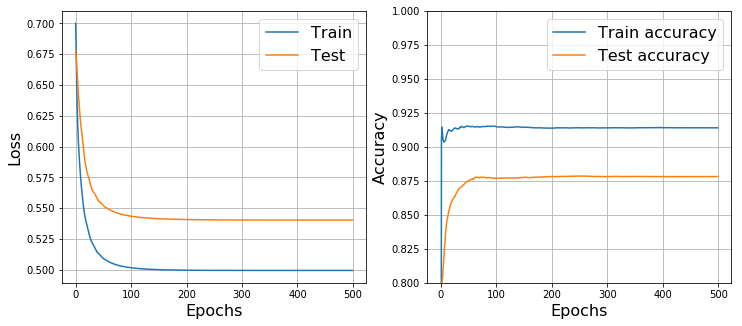

Params: lr - 1E-02, alpha - 1E-03
Score: train - 0.914040, test - 0.878160


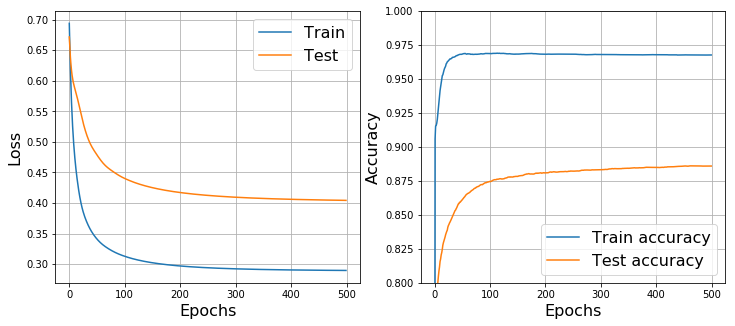

Params: lr - 1E-02, alpha - 1E-04
Score: train - 0.967680, test - 0.885920


In [59]:
for lr in [1e-2]:
    for alpha in [1e-3, 1e-4]:
        model = LogReg(lr=lr, C=alpha, epochs=500)
        model.fit(X_train_scaled, y_train, X_dev_scaled, y_dev)
        plot(model)
        print("Params: lr - %.0E, alpha - %.0E" %(lr, alpha))
        print('Score: train - %f, test - %f' %(model.score(X_train_scaled, y_train), model.score(X_dev_scaled, y_dev)))

Сильных улучшений не замечено

Тестируем на лучшей модели

In [53]:
ngram_range = (1, 3)
tokenized_train_texts = get_tokens(train_texts, ngram_range)
tokenized_dev_texts = get_tokens(dev_texts, ngram_range)

vocab = get_vocab()
X_train, X_dev, vocabulary = get_matrix()
X_train.shape, X_dev.shape

Ответ 1: размер словаря - 5072444


((25000, 5072444), (25000, 5072444))

In [54]:
X_train_scaled = maxabs_scale(X_train)
X_dev_scaled = maxabs_scale(X_dev)

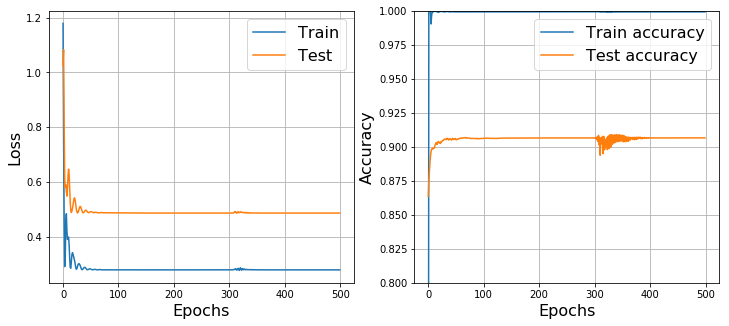

Params: lr - 1E-02, alpha - 1E-03
Score: train - 0.999360, test - 0.906640


In [55]:
for lr in [1e-2]:
    for alpha in [1e-3]:
        model = LogReg(lr=lr, C=alpha, epochs=500)
        model.fit(X_train_scaled, y_train, X_dev_scaled, y_dev)
        plot(model)
        print("Params: lr - %.0E, alpha - %.0E" %(lr, alpha))
        print('Score: train - %f, test - %f' %(model.score(X_train_scaled, y_train), model.score(X_dev_scaled, y_dev)))

Результаты немного улучшилиь, но такую нормировку включать в лучшую модель нельзя. 

В целом нормирование признаков не должно сильно влиять на результат, т.к. для логистической регресси это не имеет значения

Итог:

Лучшая модель - логрег с адамом уни-би-триграммамми. В целом пришлось выбирать темп обучения такой, чтобы обучение не занимало слишком много времени.

In [46]:
assert "good" in vocab
assert all(x not in vocab for x in STOPWORDS)
assert len(vocab) == VOCAB_SIZE + 1

In [54]:
# sanity check
for counter in [positive_class_word_counter, negative_class_word_counter]:
    assert counter["think"] > 1000
    assert min(counter.values()) > 0
    assert all(isinstance(x, int) for x in counter.values())